# Chapter 5: Evaluating Predictive Performance

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.


## Import required packages

Make sure DMBA package is available

In [1]:
pip install dmba

Note: you may need to restart the kernel to use updated packages.


In [1]:
import math
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pylab as plt

import dmba
from dmba import regressionSummary, classificationSummary, liftChart, gainsChart

%matplotlib inline


## Table 5.1
Load file and generate training and validation sets. 

In [2]:
# Load data frame and select columns for regression analysis
car_df = dmba.load_data('ToyotaCorolla.csv')

# create a list of predictor variables by remvoing output variables and text columns
excludeColumns = ('Price', 'Id', 'Model', 'Fuel_Type', 'Color')
predictors = [s for s in car_df.columns if s not in excludeColumns]
outcome = 'Price'

# partition data
X = car_df[predictors]
y = car_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# train linear regression model
reg = LinearRegression()
reg.fit(train_X, train_y)

# evaluate performance
# training
regressionSummary(train_y, reg.predict(train_X))
# validation
regressionSummary(valid_y, reg.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1121.0606
            Mean Absolute Error (MAE) : 811.6770
          Mean Percentage Error (MPE) : -0.8630
Mean Absolute Percentage Error (MAPE) : 8.0054

Regression statistics

                      Mean Error (ME) : 97.1891
       Root Mean Squared Error (RMSE) : 1382.0352
            Mean Absolute Error (MAE) : 880.1396
          Mean Percentage Error (MPE) : 0.0138
Mean Absolute Percentage Error (MAPE) : 8.8744


## Figure 5.1

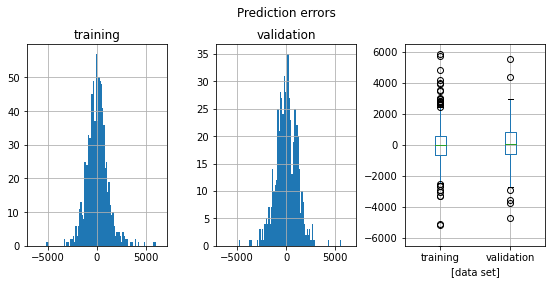

In [3]:
pred_error_train = pd.DataFrame({
    'residual': train_y - reg.predict(train_X), 
    'data set': 'training'
})
pred_error_valid = pd.DataFrame({
    'residual': valid_y - reg.predict(valid_X), 
    'data set': 'validation'
})
boxdata_df = pd.concat([pred_error_train, pred_error_valid])

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(9, 4)
common = {'bins': 100, 'range': [-6500, 6500]}
pred_error_train.hist(ax=axes[0], **common)
pred_error_valid.hist(ax=axes[1], **common)
boxdata_df.boxplot(ax=axes[2], by='data set')

axes[0].set_title('training')
axes[1].set_title('validation')
axes[2].set_title(' ')
axes[2].set_ylim(-6500, 6500)
plt.suptitle('Prediction errors') 
plt.subplots_adjust(bottom=0.15, top=0.85, wspace=0.35)

plt.show()

## Figure 5.2

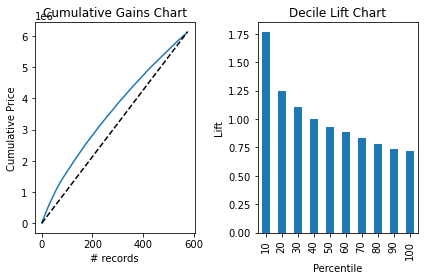

Lift based on meanResponse 1.7618191980414206
Expected cumulative price for 10% random sales 613291.8
Cumulative price for top 10% sales 1089905
Lift calculated based on gains chart 1.777139364980911


In [4]:
# sort the actual values in descending order of the prediction
df = pd.DataFrame({
    'predicted': reg.predict(valid_X),
    'actual': valid_y, 
})
df = df.sort_values(by=['predicted'], ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(df['actual'], ax=axes[0])
ax.set_ylabel('Cumulative Price')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(df['actual'], ax=axes[1], labelBars=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()


# group the sorted predictions into 10 roughly equal groups and calculate the mean
sorted_act_v = df['actual']
groups = [int(10 * i / len(sorted_act_v)) for i in range(len(sorted_act_v))]
meanPercentile = sorted_act_v.groupby(groups).mean()
meanResponse = meanPercentile / sorted_act_v.mean()
meanResponse.index = (meanResponse.index + 1) * 10
print('Lift based on meanResponse', meanResponse[10])
random10 = sorted_act_v.cumsum().iloc[-1] / 10  # expected cumulative price without lift for 10% sales
cumPred10 = sorted_act_v.cumsum().iloc[57]  # cumulative price based on model for top 10%
print('Expected cumulative price for 10% random sales', random10)
print('Cumulative price for top 10% sales', cumPred10)
print('Lift calculated based on gains chart', cumPred10 / random10)

## Table 5.5

In [5]:
owner_df = dmba.load_data('ownerExample.csv')
owner_df.head()
class_names = ['nonowner', 'owner']

In [6]:
predicted = ['owner' if p > 0.5 else 'nonowner' for p in owner_df.Probability]
classificationSummary(owner_df.Class, predicted, class_names=class_names)

Confusion Matrix (Accuracy 0.8750)

         Prediction
  Actual nonowner    owner
nonowner       10        2
   owner        1       11


In [8]:
predicted = ['owner' if p > 0.25 else 'nonowner' for p in owner_df.Probability]
classificationSummary(owner_df.Class, predicted, class_names=class_names)

Confusion Matrix (Accuracy 0.7917)

         Prediction
  Actual nonowner    owner
nonowner        8        4
   owner        1       11


In [9]:
predicted = ['owner' if p > 0.75 else 'nonowner' for p in owner_df.Probability]
classificationSummary(owner_df.Class, predicted, class_names=class_names)

Confusion Matrix (Accuracy 0.7500)

         Prediction
  Actual nonowner    owner
nonowner       11        1
   owner        5        7


## Figure 5.4
Calculate the accuracy at different cutoff values and create a graph.

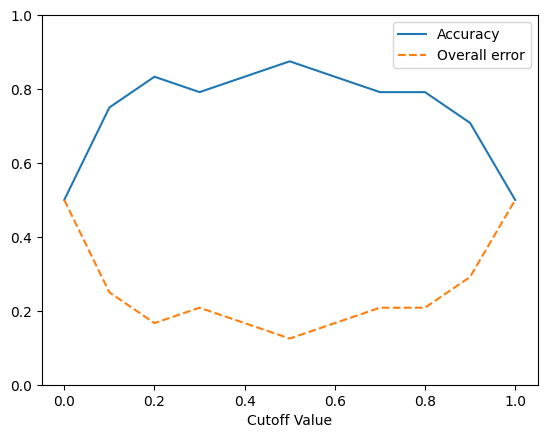

In [10]:
df = dmba.load_data('liftExample.csv')

cutoffs = [i * 0.1 for i in range(0, 11)]
accT = []
for cutoff in cutoffs:
    predicted = [1 if p > cutoff else 0 for p in df.prob]
    accT.append(accuracy_score(df.actual, predicted))

line_accuracy = plt.plot(cutoffs, accT, '-', label='Accuracy')[0]
line_error = plt.plot(cutoffs, [1 - acc for acc in accT], '--', label='Overall error')[0]
plt.ylim([0,1])
plt.xlabel('Cutoff Value')
plt.legend(handles=[line_accuracy, line_error])

plt.show()

## Figure 5.5

In [11]:
fpr, tpr, _ = roc_curve(df.actual, df.prob)
roc_auc = auc(fpr, tpr)

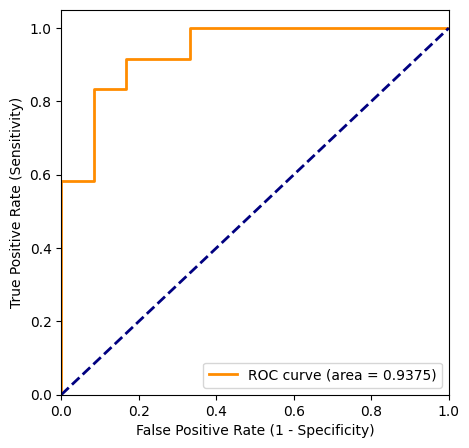

In [12]:
plt.figure(figsize=[5, 5])
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")

plt.show()

## Figure 5.6

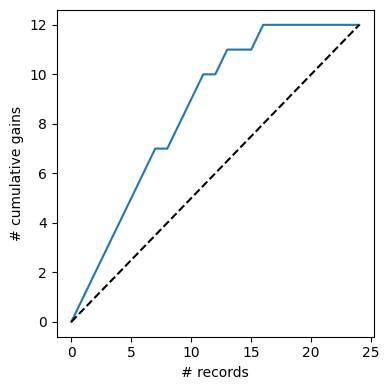

In [13]:
df = dmba.load_data('liftExample.csv')
df = df.sort_values(by=['prob'], ascending=False)

gainsChart(df.actual, figsize=(4, 4))

plt.tight_layout()
plt.show()

## Figure 5.7
The created figure differs from the R version of the graph due to variations in the assignment to the percentiles.

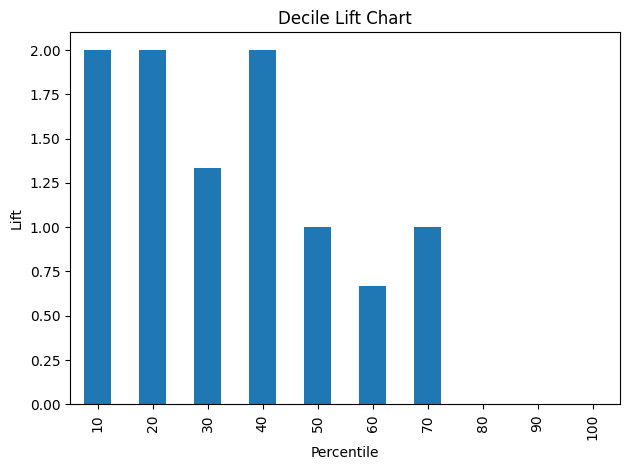

In [14]:
liftChart(df.actual, labelBars=False)
plt.tight_layout()
plt.show()